In [67]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import math
import numpy as np
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm, trange
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.path import Path
from matplotlib.patches import Rectangle, PathPatch
from tensorflow import keras as K
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

# sys.path.append('../../SketchRNN_tf2')
from sketchrnn_ouatai import models, dataset, utils

sns.set('notebook', 'whitegrid', rc=utils.mpl_rc())

print("tf: {}".format(tf.version.VERSION))
print("tf.keras: {}".format(K.__version__))

tf: 2.6.0
tf.keras: 2.6.0


In [2]:
import IProgress
import ipywidgets
import random
from PIL import Image
import io
import pandas as pd

## dessine moi un objet

In [3]:
best_images = {
    'bulldozer': np.load('../../raw_data/Best_images/best_bulldozer.npy', allow_pickle=True),
    'rabbit' : np.load('../../raw_data/Best_images/best_rabbit.npy', allow_pickle=True), 
    'cat' : np.load('../../raw_data/Best_images/best_cat.npy', allow_pickle=True)
}

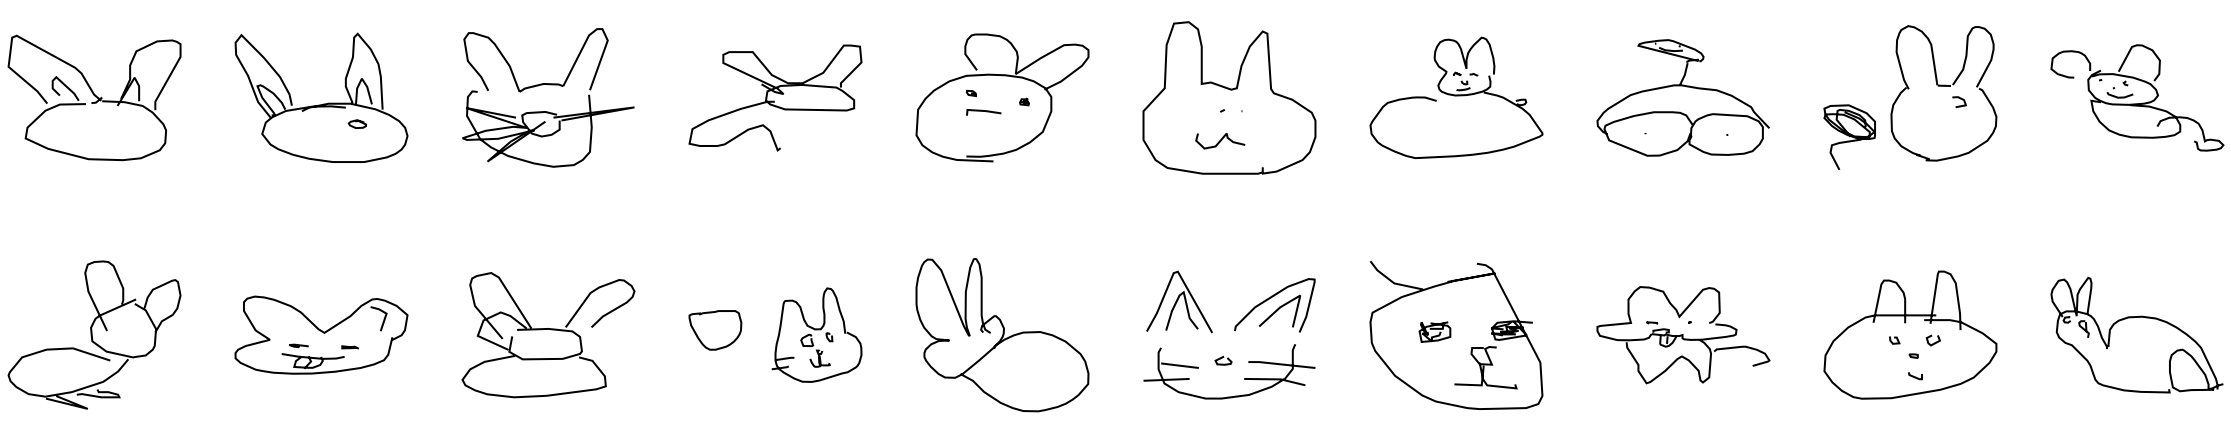

In [86]:
word = 'rabbit'
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for index, ax in enumerate(axs[0]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[word][index]))
for index, ax in enumerate(axs[1]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[word][index+10]))

In [87]:
def dessine_moi_un(word, temperature = 0.3, color = 'black', zoom = 1):
    words = ['bulldozer', 'cat', 'rabbit']
    if word not in words:
        return 'essaie un autre mot stp'
    
    #test de variables random
    max_seq_len = best_images[word][0].shape[0]-1
    data_train = [1 for k in range(10000)]
    
    hps = {
        "max_seq_len": max_seq_len,
        'batch_size': 100,
        "num_batches": math.ceil(len(data_train) / 100),
        "epochs": 1,
        "recurrent_dropout_prob": 0.1,
        "enc_rnn_size": 256,
        "dec_rnn_size": 512,
        "z_size": 128,
        "num_mixture": 20,
        "learning_rate": 0.001,
        "min_learning_rate": 0.00001,
        "decay_rate": 0.9999,
        "grad_clip": 1.0,
        'kl_tolerance': 0.2,
        'kl_decay_rate': 0.99995,
        "kl_weight": 0.5,
        'kl_weight_start': 0.01,
    }
    
    # load model
    sketchrnn = models.SketchRNN(hps)
    initial_epoch, initial_loss = 100, 0.06
    
    fichiers = {
        'bulldozer': 'sketch_rnn_bulldozer_weights.79_0.21.hdf5', 
        'cat' : 'sketch_rnn_cat_weights.78_0.01.hdf5',
        'rabbit' : 'sketch_rnn_rabbit_weights.100_0.06.hdf5'
               }
    checkpoint = os.path.join('../../SketchRNN_tf2/models/', fichiers[word])
    sketchrnn.load_weights(checkpoint);
    
    
    # building image 
    best_pic = random.choice(best_images[word])
    d = np.expand_dims(best_pic,0)
    z = sketchrnn.models['encoder'].predict(d[:,1:])[0]
    strokes = sketchrnn.sample(z=z, temperature=temperature)
    
    final_object = utils.to_normal_strokes(strokes)
    figsize = (3*zoom,3*zoom)
    fig, ax = plt.subplots(figsize=figsize);
    utils.plot_strokes(ax, final_object, ec = color);
#     utils.plt_save(filename = '../../raw_data/Best_images/best_'+word+'.svg', facecolor = 'red')
#     plt.savefig(fname = '../../raw_data/Best_images/best_'+word+'.png', facecolor = background)
    
    # figure to PIL image
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    image = Image.open(buf)
#     image.save("../../raw_data/Best_images/best_cat_buffer.png")
    image = image.copy()
    buf.close()
    return image

## la scene

In [88]:
scene_size = (2_000, 1_000)

In [89]:
def construis_la_scene(list_objects, scene_size = scene_size):
    '''
    list_objects = [[img_obj1, position_obj1], ...]
    '''
    scene = Image.new('RGBA', scene_size)
    for obj in list_objects:
        scene.paste(obj[0], obj[1])
    return scene

In [94]:
def df_to_scene(df, scene_size = scene_size):
    list_objects = []
    vertical_positions = {
        'top' : 0,
        'centre' : int(scene_size[1]/3),
        'bottom' : int(2*scene_size[1]/3)
    }
    horizontal_positions = {
        'left' : 0,
        'middle' : int(scene_size[0]/3),
        'right' : int(2*scene_size[0]/3)
    }
    sizes = {
        'small' : 1/2,
        'medium' : 1,
        'big' : 3
    }
    
    for index, row in df.iterrows():
        for n in range(int(row['num'])):
            category = row['category']
            color = row['color']
            size = sizes[row['size']]
            hor = horizontal_positions[row['horizontal_position']]
            vert = vertical_positions[row['vertical_position']]
            image = dessine_moi_un(category, color = color, zoom = size)
            list_objects.append([image, (hor, vert)])
    
    return construis_la_scene(list_objects, scene_size)

In [95]:
df = pd.DataFrame(np.array([['cat', 'blue', 'small', 3, 'centre', 'middle'], 
                             ['bulldozer', 'orange', 'big', 1, 'bottom', 'right'], 
                             ['rabbit', 'brown', 'medium', 1, 'top', 'left'],
                             ['rabbit', 'red', 'medium', 2, 'bottom', 'middle']
                            ]),
                   columns=['category', 'color', 'size', 'num', 'vertical_position', 'horizontal_position'])
df

,category,color,size,num,vertical_position,horizontal_position
0,cat,blue,small,3,centre,middle
1,bulldozer,orange,big,1,bottom,right
2,rabbit,brown,medium,1,top,left
3,rabbit,red,medium,2,bottom,middle


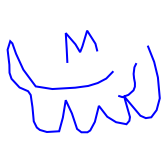

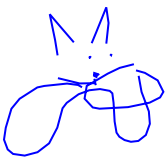

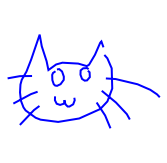

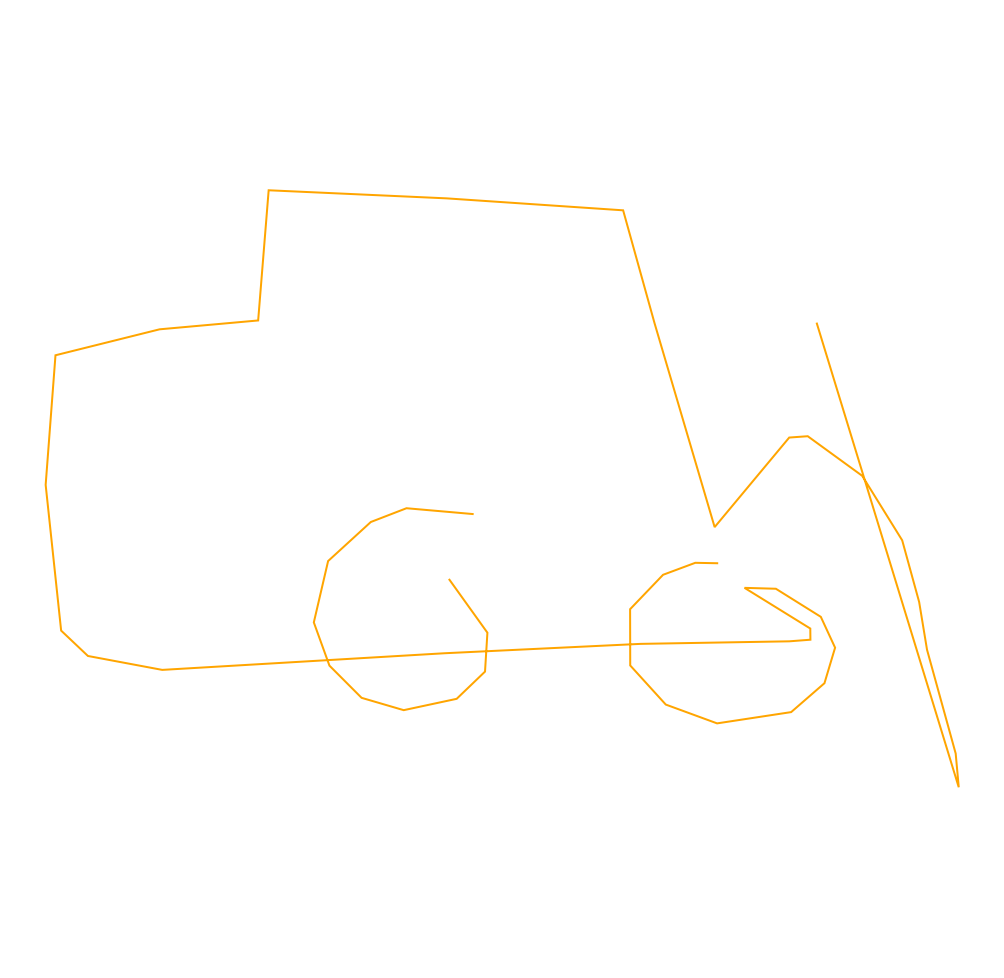

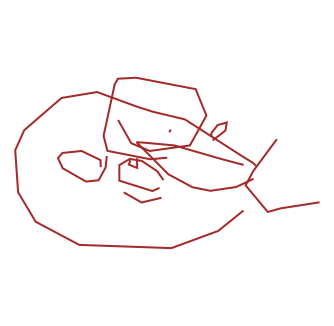

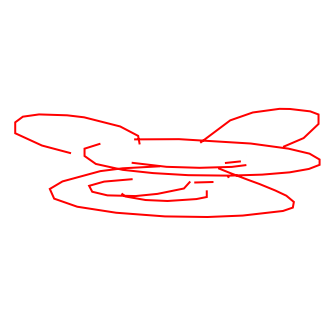

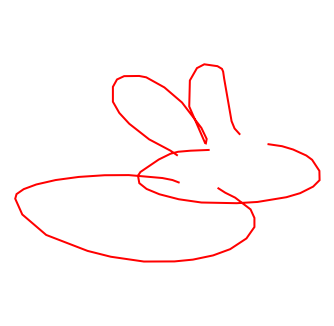

In [98]:
scene = df_to_scene(df)

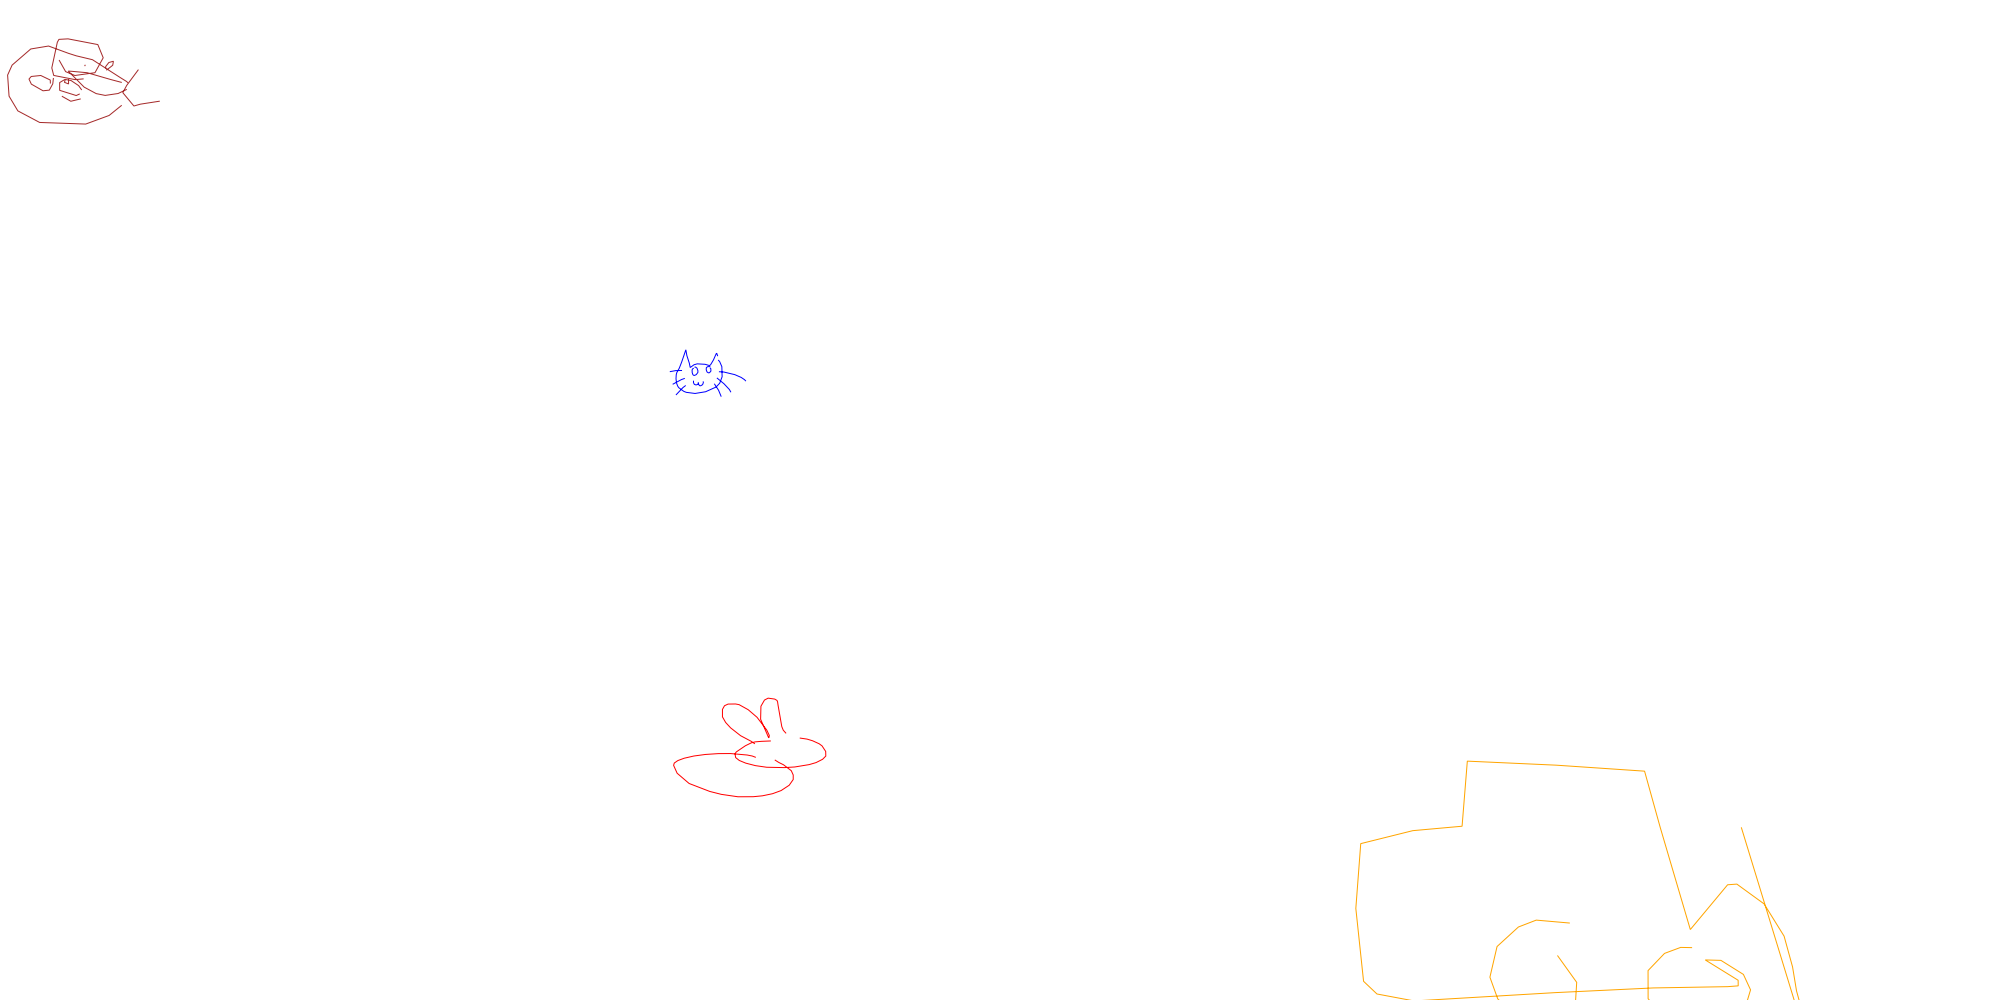

In [99]:
scene

In [100]:
!pwd

/home/etiennesdb/code/Tchook115/ouatai/notebooks


In [102]:
with open('../../raw_data/Sorted_cat.txt') as f:
    lines = f.readlines()

In [109]:
kept_cats = []
for line in lines:
    if line[0] != '#':
        kept_cats.append(line[:-1])

In [110]:
kept_cats

['airplane',
 'angel',
 'ant',
 'apple',
 'banana',
 'basket',
 'bat',
 'bear',
 'bed',
 'bee',
 'bench',
 'bicycle',
 'bird',
 'book',
 'boomerang',
 'bread',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'camel',
 'camera',
 'candle',
 'car',
 'carrot',
 'cat',
 'cello',
 'chair',
 'church',
 'circle',
 'clock',
 'cloud',
 'cookie',
 'cow',
 'crab',
 'crocodile',
 'crown',
 'cup',
 'diamond',
 'dog',
 'dolphin',
 'donut',
 'door',
 'dragon',
 'drums',
 'elephant',
 'envelope',
 'eraser',
 'eyeglasses',
 'face',
 'feather',
 'fence',
 'firetruck',
 'fish',
 'flamingo',
 'flashlight',
 'flower',
 'fork',
 'frog',
 'giraffe',
 'grapes',
 'grass',
 'guitar',
 'hamburger',
 'hammer',
 'harp',
 'hat',
 'headphones',
 'hedgehog',
 'helicopter',
 'horse',
 'hourglass',
 'house',
 'ice cream',
 'jail',
 'key',
 'knife',
 'ladder',
 'laptop',
 'leaf',
 'lighter',
 'lightning',
 'lollipop',
 'mailbox',
 'mermaid',
 'microphone',
 'moon',
 

In [126]:
liste_Tchook, liste_romain, liste_etienne = [],[],[]
for index, line in enumerate(kept_cats):
    if index%3==0:
        liste_Tchook.append(line)
    if index%3==1:
        liste_romain.append(line)
    if index%3==2:
        liste_etienne.append(line)

In [128]:
liste_Tchook

['airplane',
 'apple',
 'bat',
 'bee',
 'bird',
 'bread',
 'bulldozer',
 'butterfly',
 'calculator',
 'candle',
 'cat',
 'church',
 'cloud',
 'crab',
 'cup',
 'dolphin',
 'dragon',
 'envelope',
 'face',
 'firetruck',
 'flashlight',
 'frog',
 'grass',
 'hammer',
 'headphones',
 'horse',
 'ice cream',
 'knife',
 'leaf',
 'lollipop',
 'microphone',
 'motorbike',
 'mushroom',
 'owl',
 'pants',
 'pear',
 'pillow',
 'postcard',
 'radio',
 'rhinoceros',
 'saw',
 'sheep',
 'skull',
 'snake',
 'soccer ball',
 'square',
 'stereo',
 'sword',
 'teddy-bear',
 'tent',
 'train',
 't-shirt',
 'violin',
 'windmill']

In [132]:
liste_romain

['angel',
 'banana',
 'bear',
 'bench',
 'book',
 'broom',
 'bus',
 'cactus',
 'camel',
 'car',
 'cello',
 'circle',
 'cookie',
 'crocodile',
 'diamond',
 'donut',
 'drums',
 'eraser',
 'feather',
 'fish',
 'flower',
 'giraffe',
 'guitar',
 'harp',
 'hedgehog',
 'hourglass',
 'jail',
 'ladder',
 'lighter',
 'mailbox',
 'moon',
 'mountain',
 'ocean',
 'palm tree',
 'parachute',
 'pencil',
 'pineapple',
 'potato',
 'rain',
 'rifle',
 'school bus',
 'shorts',
 'smiley face',
 'snowflake',
 'sock',
 'stairs',
 'submarine',
 'syringe',
 'telephone',
 'The Eiffel Tower',
 'tree',
 'umbrella',
 'whale',
 'zigzag']

In [130]:
liste_etienne

['ant',
 'basket',
 'bed',
 'bicycle',
 'boomerang',
 'bucket',
 'bush',
 'cake',
 'camera',
 'carrot',
 'chair',
 'clock',
 'cow',
 'crown',
 'dog',
 'door',
 'elephant',
 'eyeglasses',
 'fence',
 'flamingo',
 'fork',
 'grapes',
 'hamburger',
 'hat',
 'helicopter',
 'house',
 'key',
 'laptop',
 'lightning',
 'mermaid',
 'mosquito',
 'mug',
 'onion',
 'panda',
 'peanut',
 'pig',
 'pizza',
 'rabbit',
 'rainbow',
 'sailboat',
 'scissors',
 'skateboard',
 'snail',
 'snowman',
 'spider',
 'star',
 'sun',
 'table',
 'television',
 'tornado',
 'truck',
 'van',
 'wheel']